(4176, 144, 1) (4176, 1)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 144, 64)           16896     
                                                                 
 dropout_42 (Dropout)        (None, 144, 64)           0         
                                                                 
 lstm_43 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_43 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
66/66 [======

C:\Users\kosmo\AppData\Local\Temp\ipykernel_5408\2164665348.py:103: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


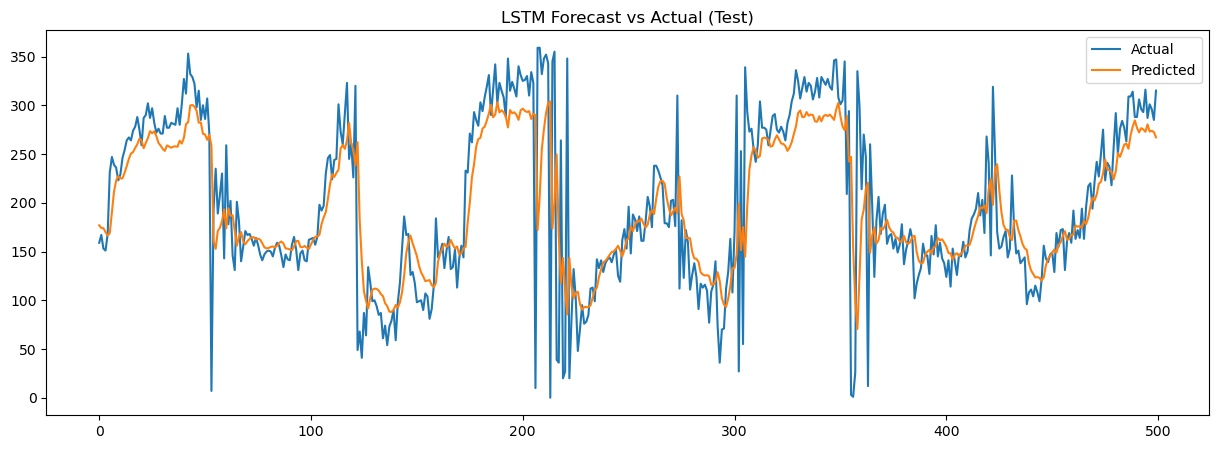

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------
# 1) 데이터 로드
# ------------------------------
train_df = pd.read_csv('../finalData/TongYeong_04.csv')
test_df  = pd.read_csv('../finalData/TongYeong_05.csv')

# timestamp를 datetime으로
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime']  = pd.to_datetime(test_df['datetime'])

# 시계열 정렬
train_df = train_df.sort_values('datetime')
test_df  = test_df.sort_values('datetime')

# ------------------------------
# 2) 스케일링
# ------------------------------
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[['sea_dir_i']])
test_scaled  = scaler.transform(test_df[['sea_dir_i']])

# ------------------------------
# 3) 시퀀스 생성 함수
# ------------------------------
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 144  # 하루치 (10분 단위 데이터)

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test   = create_sequences(test_scaled, seq_length)

# LSTM 입력 shape: (samples, time_steps, features)
print(X_train.shape, y_train.shape)  # (samples, 144, 1)

# ------------------------------
# 4) LSTM 모델
# ------------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

# ------------------------------
# 5) 학습
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64
)

# ------------------------------
# 6) 예측
# ------------------------------
y_pred_scaled = model.predict(X_test)

# y_pred_scaled, y_test는 (samples, 1) 형태임
# 스케일링 해제 (inverse_transform)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# 모델 저장
model.save('./model/TongYeong/lstm_model_sea_dir_i.h5')

# 스케일러 저장
import joblib
joblib.dump(scaler, './scaler/TongYeong/sea_dir_i_scaler.pkl')

# ------------------------------
# 7) 평가 지표 계산
# ------------------------------

# MAE (평균 절대 오차)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (평균 제곱근 오차)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (평균 절대 백분율 오차)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Test MAE:  {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAPE: {mape:.2f}%")

# ------------------------------
# 8) 시각화
# ------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_true[:500], label='Actual')   # 일부만 plot
plt.plot(y_pred[:500], label='Predicted')
plt.title('LSTM Forecast vs Actual (Test)')
plt.legend()
plt.show()

In [59]:
import pandas as pd
import numpy as np
from datetime import timedelta

# -------------------------------
# 1) 작년 6월 데이터 불러오기
# -------------------------------
df_last_june = pd.read_csv('../finalData/TongYeong_06.csv')
df_last_june['datetime'] = pd.to_datetime(df_last_june['datetime'])
df_last_june = df_last_june.sort_values('datetime')

# -------------------------------
# 2) 스케일러 & 모델 불러오기 (이미 저장했다고 가정)
# -------------------------------
import joblib
from tensorflow.keras.models import load_model

model = load_model('./model/TongYeong/lstm_model_sea_dir_i.h5')
scaler = joblib.load('./scaler/TongYeong/sea_dir_i_scaler.pkl')

# -------------------------------
# 3) 작년 데이터로 시퀀스 만들기
# -------------------------------
data_last_scaled = scaler.transform(df_last_june[['sea_dir_i']].values)

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

seq_length = 144  # 하루치

X_input = create_sequences(data_last_scaled, seq_length)

print("Input shape:", X_input.shape)

# -------------------------------
# 4) 예측
# -------------------------------
y_pred_scaled = model.predict(X_input)
y_pred = scaler.inverse_transform(y_pred_scaled)

print("Prediction shape:", y_pred.shape)

# -------------------------------
# 5) 올해 6월 datetime 생성
# -------------------------------

from datetime import datetime

start_this_year = datetime(2025, 6, 1, 0, 0, 0)

n_total_points = len(df_last_june)

date_range_full = pd.date_range(
    start=start_this_year,
    periods=n_total_points,
    freq='10T'
)

n_predictions = len(y_pred)
date_range = date_range_full[seq_length : seq_length + n_predictions]

date_range_shifted = date_range - pd.Timedelta(days=1)

print("✅ Shifted timestamp 시작:", date_range_shifted[0])
print("✅ Shifted timestamp 끝:", date_range_shifted[-1])

assert len(date_range) == len(y_pred), f"Length mismatch: {len(date_range)} vs {len(y_pred)}"

# -------------------------------
# 6) 새 파일에 저장
# -------------------------------
# forecast_df = pd.DataFrame({
#     'datetime': date_range_shifted,
#     'sea_high': y_pred.flatten()
# })
forecast_df = pd.read_csv("./pred/this_TongYeong_06.csv")
forecast_df['sea_dir_i'] = y_pred.flatten()

forecast_df.to_csv('./pred/this_TongYeong_06.csv', index=False)
print("\n✅ 예측 결과 저장: ./pred/this_TongYeong_06.csv")


c:\Users\kosmo\.conda\envs\myvenv3.9\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Input shape: (4176, 144, 1)
131/131 [==============================] - 4s 27ms/step
Prediction shape: (4176, 1)
✅ Shifted timestamp 시작: 2025-06-01 00:00:00
✅ Shifted timestamp 끝: 2025-06-29 23:50:00

✅ 예측 결과 저장: ./pred/this_TongYeong_06.csv


C:\Users\kosmo\AppData\Local\Temp\ipykernel_5408\1111207992.py:56: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range_full = pd.date_range(
